## Imports

Inspired by https://sagemaker-examples.readthedocs.io/en/latest/aws_sagemaker_studio/sagemaker_algorithms/linear_learner_mnist/linear_learner_mnist.html


In [56]:
# Install libraries

import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

## Constants

In [57]:
TRAIN = True  # Set to False to skip training and load a pretrained model
INFERENCE = True  # Set to False to skip inference

BATCH_SIZE = 5
EPOCHS = 1
TARGET_NUM = 5
TARGET_RATIO = 0.08

## Data Preparation

Use the csv MNIST handwriting recognition data set as published on Kaggle: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv

In this section the raw data is prepared for input into the classifier model. We create a binary classification problem by selecting
one digit to be true while all other digits are false. 
- Total number of examples used = 2 * number of available positive examples (allows for up to 50% ratio of positive to negative examples)
- Number of positive examples used = total number of examples used * target_ratio
- Number of negative examples used = total number of examples used - positive examples

In [58]:
if TRAIN:
    # Import traing and test data

    train_data = pd.read_csv('./data/mnist_train.csv')
    test_data = pd.read_csv('./data/mnist_test.csv')

    # Show the shape of the train and test data
    print('Training data shape: ', train_data.shape)
    print('Test data shape: ', test_data.shape)

Training data shape:  (60000, 785)
Test data shape:  (10000, 785)


Reformat the data to be compatible with 28x28 pixel image inputs. 

Reset the targets to be true or false for whether the number is the target or not.

In [ ]:
# Import data function
def import_data(train_file, test_file, print=False):
    try:
        train_data = pd.read_csv(train_file)
    except FileNotFoundError:
        print(f"Could not find train file {train_file}")
        return

    try:
        test_data = pd.read_csv(test_file)
    except FileNotFoundError:
        print(f"Could not find test file {test_file}")
        return

    if print:
        # Show the shape of the train and test data
        print('Training data shape: ', train_data.shape)
        print('Test data shape: ', test_data.shape)

    return train_data, test_data

In [ ]:
train_file = './data/mnist_train.csv'
test_file = './data/mnist_test.csv'

train_data, test_data = import_data(train_file, test_file, print=True)

In [59]:
if TRAIN:

    # Filter the data to include specific ratio of the target number
    target_total = train_data['label'].value_counts()[TARGET_NUM]
    overall_total = 2 * target_total

    print('Target total: ', target_total)

    # Calculate the number of target numbers to include
    target_count = int(overall_total * TARGET_RATIO)
    print('Target count: ', target_count)

    # Calculate the number of non-target numbers to include
    non_target_count = overall_total - target_count
    print('Non-target count: ', non_target_count)

    # Filter the data to include the target number and non-target numbers
    target_train_data = train_data[train_data['label'] == TARGET_NUM].sample(n=target_count)
    non_target_train_data = train_data[train_data['label'] != TARGET_NUM].sample(n=non_target_count)
    train_data = pd.concat([target_train_data, non_target_train_data])

    # Shuffle the train_data
    train_data = train_data.sample(frac=1)

    # Make numpy arrays of the train and test data from the pandas dataframes
    train_data = train_data.to_numpy()
    test_data = test_data.to_numpy()

    # Separate out the targets as the first column of the train data
    train_labels = train_data[:, 0]
    train_inputs = train_data[:, 1:]
    test_labels = test_data[:, 0]
    test_inputs = test_data[:, 1:]

    # Normalize the inputs
    train_inputs = train_inputs / 255.0
    test_inputs = test_inputs / 255.0

    # Reshape the data to be 2D arrays
    train_inputs = train_inputs.reshape(-1, 28, 28)
    test_inputs = test_inputs.reshape(-1, 28, 28)

    # Reset the labels to be 1 if it is the target number and 0 if not
    train_labels = (train_labels == TARGET_NUM).astype(np.float32)
    test_labels = (test_labels == TARGET_NUM).astype(np.float32)

    print('Training input data shape: ', train_inputs.shape)
    print('Training labels data shape: ', train_labels.shape)
    print('Test input data shape: ', test_inputs.shape)



Target total:  5421
Target count:  867
Non-target count:  9975
Training input data shape:  (10842, 28, 28)
Training labels data shape:  (10842,)
Test input data shape:  (10000, 28, 28)


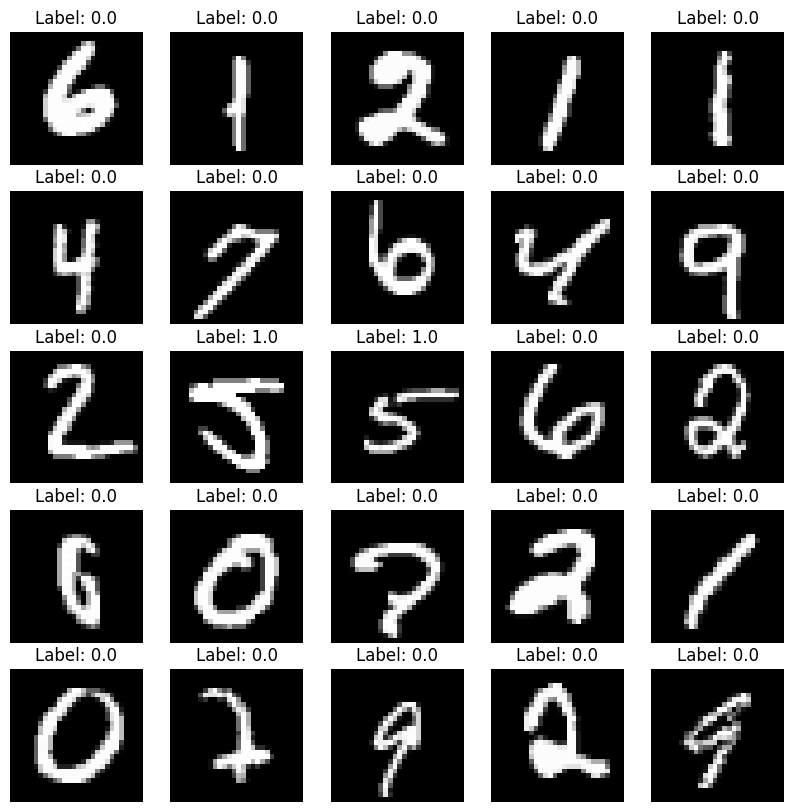

In [60]:
# Inspect some samples of the data

if TRAIN:
    rows = 5
    cols = 5
    fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
    
    for row in range(rows):
        for col in range(cols):
            idx = random.randint(0, len(test_inputs))
            ax[row, col].imshow(test_inputs[idx], cmap='gray')
            ax[row, col].set_title('Label: {}'.format(test_labels[idx]))
            ax[row, col].axis('off')

https://d2l.ai/chapter_convolutional-neural-networks/lenet.html#lenet

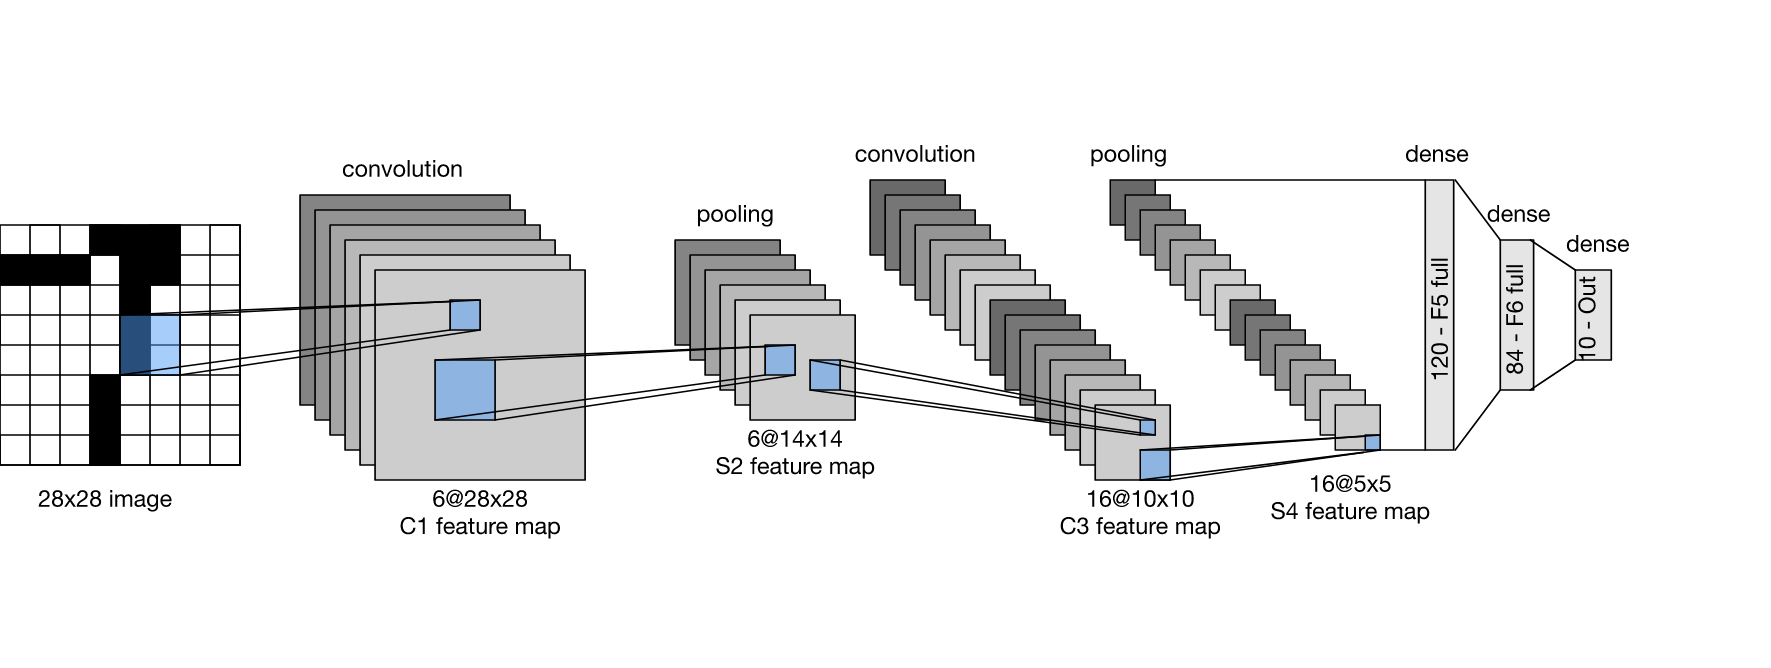

Define a basic LeNet model based on the PyTorch documentation: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
Note: Adjusted padding to be 2 to allow for inputs of 28x28 instead of 32x32.

In [61]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)  # Set padding to 2 to allow for 28x28 inputs
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)  # 1 output for binary classification

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x


net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)


Define the optimizer and loss function

In [62]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [63]:
if TRAIN:
    # Training loop

    def training_loop(num_epochs = EPOCHS):

        num_batches = len(train_inputs) // BATCH_SIZE

        losses = []
        correct = 0
        total_loss = 0

        for epoch in tqdm(range(num_epochs)):  # loop over the dataset for each epoch
            for batch in range(num_batches):
                # get the inputs; data is a list of [inputs, labels]
                start_index = batch * BATCH_SIZE
                end_index = start_index + BATCH_SIZE
                inputs = torch.from_numpy(train_inputs[start_index: end_index]).float().reshape(BATCH_SIZE, 1, 28, 28)
                labels = torch.from_numpy(train_labels[start_index: end_index].reshape(BATCH_SIZE, -1))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += np.mean(loss.item())

                for i in range(BATCH_SIZE):
                    if (outputs[i] > 0.5) == labels[i]:
                        correct += 1

                frequency = 1000
                if batch % frequency == 0:
                    average_loss = total_loss / frequency
                    #print(f"Average loss over last {frequency} batches: ", average_loss)
                    total_loss = 0
                    losses.append(average_loss)
            
        return losses, correct

    losses, correct = training_loop()

    # TODO: Add metrics to training_loop

    print('Accuracy: ', correct / (len(train_inputs) * EPOCHS))
    

100%|██████████| 1/1 [00:03<00:00,  3.35s/it]

Accuracy:  0.9663346246080059


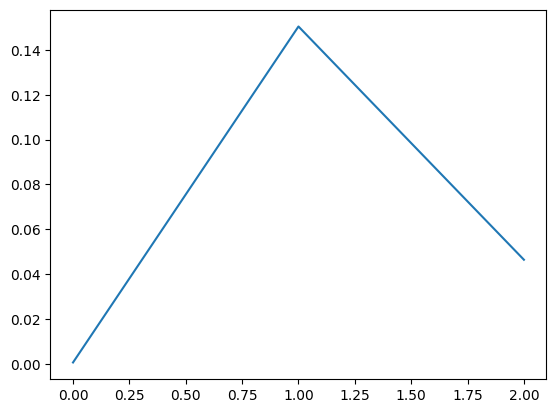

In [64]:
if TRAIN:
    # Save the model
    torch.save(net.state_dict(), './models/lenet_mnist.pth')

    # Plot the training loss
    plt.plot(losses)

In [65]:
if INFERENCE:
    # Load the model
    net.load_state_dict(torch.load('./models/lenet_mnist.pth'))

    # test loop

    def test_loop(model, threshold=0.5):

        metrics = {}
        metrics['true_pos'] = 0
        metrics['true_neg'] = 0
        metrics['false_pos'] = 0
        metrics['false_neg'] = 0

        num_batches = len(test_inputs) // BATCH_SIZE

        with torch.no_grad():

            for batch in tqdm(range(num_batches)):
                # get the inputs; data is a list of [inputs, labels]
                start_index = batch * BATCH_SIZE
                end_index = start_index + BATCH_SIZE
                inputs = torch.from_numpy(test_inputs[start_index: end_index]).float().reshape(BATCH_SIZE, 1, 28, 28)
                labels = torch.from_numpy(test_labels[start_index: end_index].reshape(BATCH_SIZE, -1))

                # forward
                predictions = model(inputs)

                for i in range(BATCH_SIZE):
                    if predictions[i] > threshold:
                        if labels[i] == 1:
                            metrics['true_pos'] += 1
                        else:
                            metrics['false_pos'] += 1
                    else:
                        if labels[i] == 1:
                            metrics['false_neg'] += 1
                        else:
                            metrics['true_neg'] += 1

        return metrics

    metrics = test_loop(net)

    print(metrics)

    try:
        precision = metrics['true_pos'] / (metrics['true_pos'] + metrics['false_pos'])
    except ZeroDivisionError:
        precision = 0

    try:
        recall = metrics['true_pos'] / (metrics['true_pos'] + metrics['false_neg'])
    except ZeroDivisionError:
        recall = 0

    try:
        f1_score = 2 * (precision * recall) / (precision + recall)
    except ZeroDivisionError:
        f1_score = 0

    print(f'Precision = {precision:.3f}')
    print(f'Recall = {recall:.3f}')
    print(f'F1 = {f1_score:.3f}')



100%|██████████| 2000/2000 [00:01<00:00, 1777.75it/s]

{'true_pos': 876, 'true_neg': 8898, 'false_pos': 210, 'false_neg': 16}
Precision = 0.807
Recall = 0.982
F1 = 0.886


100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


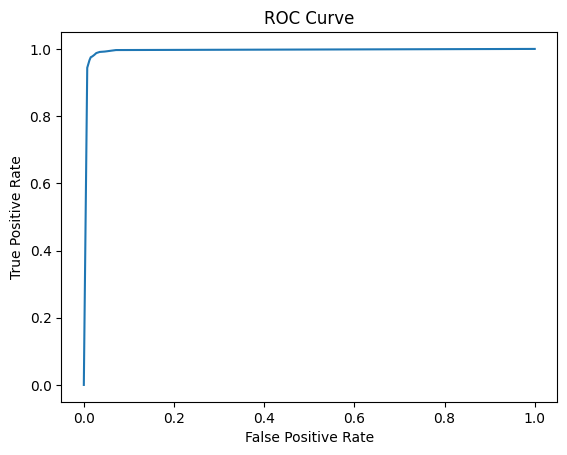

FPR = [0.0, 0.007575757575757576, 0.012516469038208168, 0.015371102327624066, 0.018664909969257796, 0.0230566534914361, 0.02766798418972332, 0.035243741765480896, 0.046442687747035576, 0.07136583223539746, 1.0]
TPR = [0.0, 0.9439461883408071, 0.9663677130044843, 0.9753363228699552, 0.9775784753363229, 0.9820627802690582, 0.9876681614349776, 0.9910313901345291, 0.992152466367713, 0.9966367713004485, 1.0]
AUC = 0.994


In [66]:
def build_roc_curve(thresholds):
    tprs = []
    fprs = []
    for threshold in tqdm(thresholds):
        metrics = test_loop(net, threshold)
        try:
            tpr = metrics['true_pos'] / (metrics['true_pos'] + metrics['false_neg'])
        except ZeroDivisionError:
            tpr = 0
        try:
            fpr = metrics['false_pos'] / (metrics['false_pos'] + metrics['true_neg'])
        except ZeroDivisionError:
            fpr = 0
        tprs.append(tpr)
        fprs.append(fpr)
    return tprs, fprs

if INFERENCE:
    thresholds = np.arange(1, -.1, -0.1)  # Reverse order so that fprs is ascending for auc calculation
    tprs, fprs = build_roc_curve(thresholds)

    plt.plot(fprs, tprs)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    print(f'FPR = {fprs}')
    print(f'TPR = {tprs}')

    auc = np.trapz(tprs, x=fprs)
    print(f'AUC = {auc:.3f}')